# TinyTroupe Demo: High-End Running Shoes Concept Test

**Objective:** 
Evaluate customer reception of a new running shoe concept.

**Workflow:**
1. Generate personas.
2. Simulate interviews about reactions to the new concept.
3. Extract & Analyze Results



In [ ]:
import os
# Set your API key
os.environ["OPENAI_API_KEY"] = "XXX"

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.extraction import ResultsExtractor
import tinytroupe.control as control
from datetime import datetime



!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: /Users/take/miniconda3/lib/python3.12/site-packages/tinytroupe/utils/../config.ini
Found custom config on: /Users/take/Develop/TinyTroupe/Pydata_demo/gpt-4.1-tempureture-1.3-20251209/config.ini
TinyTroupe version: 0.5.2
Current date and time (local): 2025-12-09 09:55:23
Current date and time (UTC):   2025-12-09 14:55:23

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.3
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cach

In [3]:
# Enable TinyTroupe caching
control.begin('cache_shoes_survey.json')

## 1. Design: Persona Generation (The Factory)
We define three distinct segments to test our hypothesis: 
- **Serious Runners** (run 15+ miles/week, train for races)
- **Casual Joggers** (run 1-2 times/week for health)
- **Fashion-Conscious** (wear running shoes for style)

Each persona is labeled with `runner_type` for later filtering and analysis.

In [ ]:
demography_path = "./usa.json" 

n_serious = 10
n_casual  = 10
n_fashion = 10

print(f"Targeting: Serious={n_serious}, Casual={n_casual}, Fashion={n_fashion}")

GENERATE_NEW_PERSONAS = False # Set to True to generate personas.
TinyPerson.clear_agents()

if GENERATE_NEW_PERSONAS:

    # --- Segment A: Serious Runners ---
    serious_context = """
    You are an adult Serious Runner. 
    You run 15+ miles per week and are actively training for 10Ks, half-marathons, or marathons.
    You prioritize performance, speed, and biomechanics.
    """

    print("Generating Serious Runners...")
    factory_serious = TinyPersonFactory.create_factory_from_demography(
        demography_path, 
        population_size=n_serious, 
        context=serious_context
    )
    serious_runners = factory_serious.generate_people(n_serious, temperature=1.3)

    # Add segment label to each agent
    for agent in serious_runners:
        agent.define("runner_type", "Serious Runner")
        agent.define("segment_id", 1)


    # --- Segment B: Casual Joggers ---
    casual_context = """
    You are an adult Casual Jogger. 
    You run 1-2 times a week primarily for health, stress relief, or social reasons.
    You prioritize comfort and injury prevention.
    """

    print("Generating Casual Joggers...")
    factory_casual = TinyPersonFactory.create_factory_from_demography(
        demography_path, 
        population_size=n_casual,
        context=casual_context
    )
    casual_joggers = factory_casual.generate_people(n_casual, temperature=1.3)

    # Add segment label to each agent
    for agent in casual_joggers:
        agent.define("runner_type", "Casual Jogger")
        agent.define("segment_id", 2)


    # --- Segment C: Fashion-Conscious ---
    fashion_context = """
    You are an adult Fashion-Conscious shopper.
    You do not strongly see yourself as a runner. You might jog or go to the gym occasionally, but you mostly use them for city walking, commuting, or social events.
    You care a lot about how your shoes look with your outfits, but other factors still matter.
    """

    print("Generating Fashion-Conscious...")
    factory_fashion = TinyPersonFactory.create_factory_from_demography(
        demography_path, 
        population_size=n_fashion,
        context=fashion_context
    )
    fashion_shoppers = factory_fashion.generate_people(n_fashion, temperature=1.3)

    # Add segment label to each agent
    for agent in fashion_shoppers:
        agent.define("runner_type", "Fashion-Conscious")
        agent.define("segment_id", 3)

    # --- Merge Segments ---
    panel = serious_runners + casual_joggers + fashion_shoppers
    print(f"\n✅ Total Agents Generated: {len(panel)}")

    output_folder = f"exported_personas"
    os.makedirs(output_folder, exist_ok=True)

    # Save personas with segment labels
    for agent in panel:
        print(f"--- {agent.get('name')} ---")
        print(f"   Age/Loc: {agent.get('age')}, {agent.get('residence')}")
        print(f"   Job: {agent.get('occupation')['title']}")
        print(f"   Segment: {agent.get('runner_type')}")  # Display segment info
        
        safe_name = agent.get("name").replace(" ", "_")
        filename = f"{output_folder}/{safe_name}.json"
        
        # Save to file
        agent.save_specification(filename, include_memory=False) 
        print(f"   Saved: {filename}\n")

    print(f"✅ Saved {len(panel)} personas with segment labels to {output_folder}/")


else:
    # Clear existing agents to avoid name collision
    TinyPerson.clear_agents()

    # Specify the folder containing saved personas
    output_folder = f"exported_personas"

    # Load all personas
    panel = TinyPerson.load_specifications_from_folder(
        output_folder,
        file_suffix=".json",
        suppress_memory=True
    )

    print(f"✅ Loaded {len(panel)} personas from {output_folder}\n")

    # Filter by segment (now possible with runner_type!)
    serious_runners = [a for a in panel if a.get("runner_type") == "Serious Runner"]
    casual_joggers = [a for a in panel if a.get("runner_type") == "Casual Jogger"]
    fashion_shoppers = [a for a in panel if a.get("runner_type") == "Fashion-Conscious"]

    print(f"Segment distribution:")
    print(f"  Serious Runners: {len(serious_runners)}")
    print(f"  Casual Joggers: {len(casual_joggers)}")
    print(f"  Fashion-Conscious: {len(fashion_shoppers)}")

In [ ]:
# Cache after persona generation
control.checkpoint()

## 2. Simulate: Depth Interviews (1-on-1)
We conduct individual depth interviews with each agent to avoid group dynamics and ensure pure individual opinions.

In [7]:
%%time
# Define the 3 Concepts
concepts_text = """
Here are three different shoe concepts we are developing:

**Option A: "Lightweight Comfort" **
- Ultra-light shoe with a sleek, minimalist silhouette that almost disappears on the foot for both workouts and regular runs.
- Soft yet responsive cushioning that feels comfortable at easy paces but still pops when you speed up.
- Breathable, foot-hugging upper that feels pleasant enough for daily wear, not only race day.


**Option B: "Soft Cushion Support"**
- High-cushion trainer focused on impact protection and a very stable, predictable ride.
- Thick foam midsole that absorbs shock on long walks and easy jogs, especially for cautious runners.
- A bit heavier and less nimble than a lightweight shoe, making it better for relaxed paces than fast sessions.

**Option C: "Versatile Style"**
- Classic designed shoe with a balance of function and appearance.
- Midweight cushioning that balances activity with all-day wear.
- Quality upper with distinctive details.
"""

run_ts = datetime.now().strftime("%Y%m%d_%H%M%S")


# --- Individual Depth Interview Loop ---
# Conduct 1-on-1 interviews to prevent groupthink, cross-contamination,
# and LLM context length issues that occur in large group settings.


for i, agent in enumerate(panel):
    agent_name = agent.get("name")
    print(f"[{i+1}/{len(panel)}] Interviewing: {agent_name}...")

    # Create a dedicated interview room for this agent
    room_name = f"Interview_Room_{run_ts}_{i}"
    world = TinyWorld(room_name, [agent])

    # Conduct the interview
    world.broadcast("Welcome. I'm going to show you three concepts for our new footwear line.")
    world.broadcast(f"Please look at these options:\n{concepts_text}\n\nWhich ONE (A, B, or C) is your top choice and why?")

    world.run(1)

    print(f"    ✓ Interview completed for {agent_name}\n")

[1/30] Interviewing: Ayaan Warsame Mohamed...


USER --> Ayaan Warsame Mohamed: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Ayaan Warsame Mohamed: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_0 step 1 of 1 ───────────────────────────────────

Ayaan Warsame Mohamed acts: [THINK] 
                           > All three options have their strengths, but I should consider what
                           > matters most to me as a runner and someone who spends a lot of time on
                           > my feet. Option A sounds great for speed and daily comfort, but
                           > sometimes ultra-light shoes don't give enough support for longer days
                           > or when my knees act up. Option B is tempting because of the extra
                           > cushion and stability—good for recovery runs or anyone worried about
                           > joint pain, but it might feel bulky and slow for tempo workouts. Option
                           > C seems like a nice middle ground: not too heavy, not too light, and
                           > looks good enough to wear outside of running. I do value versatility
                           > since I often go straight from a run to errands or volunteering. Still,
                           > performance and comfort are my top priorities, especially since I run
                           > almost every day and need something that won't aggravate my mild knee
                           > pain or asthma. I also like shoes that breathe well and don't feel
                           > restrictive with my orthotics.

Ayaan Warsame Mohamed acts: [TALK] 
                           > My top choice is Option C, the Versatile Style. I like that it balances
                           > cushioning and support with a classic look, so I could wear it for both
                           > running and everyday activities. Since I run almost every day but also
                           > spend a lot of time on my feet volunteering or running errands,
                           > versatility is important. I need enough cushioning to protect my knees,
                           > but I don't want something too bulky or heavy. Plus, a quality upper
                           > with good details means it will last longer and feel comfortable even
                           > after a long day. Option A sounds great for speed, but I worry it might
                           > not have enough support for longer runs or standing for hours. Option B
                           > is probably the most protective, but I prefer something lighter and
                           > more flexible. So, Option C fits my needs best.

Ayaan Warsame Mohamed acts: [DONE] 

    ✓ Interview completed for Ayaan Warsame Mohamed

[2/30] Interviewing: Diego Alejandro Mendoza...


USER --> Diego Alejandro Mendoza: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Diego Alejandro Mendoza: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_1 step 1 of 1 ───────────────────────────────────

Diego Alejandro Mendoza acts: [THINK] 
                             > Alright, so they want my opinion on these shoe concepts. Option A is
                             > all about being light and fast—sounds dope for races or speedwork,
                             > and honestly, I love that feeling when shoes barely weigh anything.
                             > Option B is more for comfort and support, like for people who just
                             > wanna chill or need extra cushion. I get it, but it sounds kinda
                             > bulky for my taste. Option C is about style and versatility—looks
                             > good, works for running and hanging out. I do care about how my kicks
                             > look, but if I gotta pick just one, I’m thinking about what I’d
                             > actually use most. For me, I’m always training, so performance
                             > matters. But I also rock my running shoes everywhere, so comfort and
                             > style count too. Still, that lightweight feel is hard to beat when
                             > you’re putting in miles.

Diego Alejandro Mendoza acts: [TALK] 
                             > Alright, if I gotta pick just one, I’m going with Option
                             > A—Lightweight Comfort. As a runner, I’m all about that light, fast
                             > feel, especially for long runs or when I’m trying to hit a new PR. I
                             > like shoes that almost disappear on my feet but still got enough
                             > cushion so my legs don’t feel trashed after. Plus, if they’re comfy
                             > enough for daily wear, that’s a win ’cause I rock my running shoes
                             > everywhere—park, errands, even family stuff. The other options sound
                             > cool, but for me, performance and that barely-there vibe come first.
                             > Gotta keep it moving, you know?

Diego Alejandro Mendoza acts: [DONE] 

    ✓ Interview completed for Diego Alejandro Mendoza

[3/30] Interviewing: David Aaron Goldstein...


USER --> David Aaron Goldstein: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> David Aaron Goldstein: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_2 step 1 of 1 ───────────────────────────────────

David Aaron Goldstein acts: [THINK] 
                           > Alright, three options for a new footwear line. Option A is all about
                           > being lightweight and versatile—sounds like a daily trainer that could
                           > double for tempo runs. Option B is the classic high-cushion, stability
                           > shoe—great for recovery days or runners who need extra support, but
                           > probably too heavy for my taste. Option C is the stylish, do-it-all
                           > option—midweight, with a focus on looks as well as function. As a
                           > serious runner who logs a lot of miles and values performance, I
                           > gravitate toward shoes that are light, responsive, and comfortable for
                           > both workouts and long runs. I also appreciate a shoe that can handle a
                           > variety of paces, since my training is pretty varied. While I respect
                           > the need for support and style, my top priority is how the shoe feels
                           > and performs on the run. Option A seems to fit my preferences best.

David Aaron Goldstein acts: [TALK] 
                           > My top choice is Option A, the "Lightweight Comfort." As someone who
                           > runs high mileage and mixes in both easy and faster sessions, I value a
                           > shoe that's light, responsive, and comfortable enough for daily wear
                           > but can still handle speedwork. The minimalist design and breathable
                           > upper are big pluses for me—nothing beats a shoe that almost disappears
                           > on your foot during a long run. While I appreciate the support and
                           > style of the other options, performance and versatility are my
                           > priorities, and Option A hits that sweet spot.

David Aaron Goldstein acts: [DONE] 

    ✓ Interview completed for David Aaron Goldstein

[4/30] Interviewing: Vivian Mei-Ling Chen...


USER --> Vivian Mei-Ling Chen: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Vivian Mei-Ling Chen: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_3 step 1 of 1 ───────────────────────────────────

Vivian Mei-Ling Chen acts: [THINK] 
                          > All three options have their merits, but I should consider my own
                          > running habits and what I value most in a shoe. As a serious runner who
                          > logs a lot of miles, I prioritize comfort, responsiveness, and
                          > versatility. Option A's lightweight design and responsive cushioning are
                          > appealing for both daily training and tempo runs. Option B sounds great
                          > for recovery days or runners who need extra support, but I usually
                          > prefer something less bulky. Option C is interesting for its style and
                          > balance, but performance is my main concern. I tend to gravitate toward
                          > shoes that feel fast and disappear on my feet, especially for long runs
                          > and workouts.

Vivian Mei-Ling Chen acts: [TALK] 
                          > My top choice is Option A, "Lightweight Comfort." As someone who runs
                          > almost every day and values both performance and comfort, I look for
                          > shoes that are light, responsive, and versatile enough for different
                          > types of runs. The minimalist design and breathable upper would work
                          > well for my daily training, and the cushioning sounds ideal for both
                          > easy miles and faster workouts. While I appreciate the support in Option
                          > B and the style in Option C, I tend to prioritize a shoe that feels fast
                          > and unobtrusive, especially for longer distances.

Vivian Mei-Ling Chen acts: [DONE] 

    ✓ Interview completed for Vivian Mei-Ling Chen

[5/30] Interviewing: James Otis Freeman...


USER --> James Otis Freeman: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> James Otis Freeman: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_4 step 1 of 1 ───────────────────────────────────

James Otis Freeman acts: [THINK] 
                        > Alright, let me think this through. Option A is all about being light and
                        > fast, which sounds good for folks who still like to pick up the pace, but
                        > I know my knees and hips don't take kindly to shoes that don't have enough
                        > cushion. Option B is focused on support and cushioning, which is mighty
                        > important for someone my age, especially with these old joints and the
                        > diabetes. I do like to walk and jog, but I ain't moving as quick as I used
                        > to. Option C is more about style and balance—looks nice, but I care more
                        > about comfort and support these days than how sharp my shoes look. I
                        > reckon Option B would be best for me, seeing as it offers the most
                        > protection and stability. Might be a little heavier, but I'd rather have
                        > that than risk hurting myself.

James Otis Freeman acts: [TALK] 
                        > Yes, sir, I believe I'd go with Option B—the Soft Cushion Support. At my
                        > age, and with these old knees, I need all the comfort and stability I can
                        > get. That thick foam sounds like it'd help with the aches on my longer
                        > walks and jogs, and I don't mind a little extra weight if it means less
                        > pain. I appreciate a shoe that lets me move steady and safe, even if I'm
                        > not setting any speed records these days. Thank you for letting me share
                        > my thoughts.

James Otis Freeman acts: [DONE] 

    ✓ Interview completed for James Otis Freeman

[6/30] Interviewing: Leilani Makanani Kawai...


USER --> Leilani Makanani Kawai: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Leilani Makanani Kawai: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_5 step 1 of 1 ───────────────────────────────────

Leilani Makanani Kawai acts: [THINK] 
                            > Hmm, these shoes all sound nice, but I have to think about what
                            > matters most for me. My knees and hips get sore, and sometimes I worry
                            > about tripping or falling, so I like shoes that feel safe and soft.
                            > But I also want something I can wear for my walks in the park and
                            > maybe to church or the store. The lightweight one sounds good for
                            > running, but I don't run fast anymore. The soft cushion support might
                            > help my joints, but if it's heavy, maybe it will make me tired. The
                            > versatile style is pretty, but I wonder if it's comfortable enough for
                            > my feet. I should pick the one that helps me stay active without
                            > hurting.

Leilani Makanani Kawai acts: [TALK] 
                            > I think I would choose Option B, the Soft Cushion Support. My knees
                            > and hips get sore sometimes, and I need shoes that help with shock and
                            > feel steady, especially on my long walks or when I'm jogging slow. The
                            > extra cushion makes me feel safer, even if the shoe is a little
                            > heavier. I don't run fast anymore, so comfort and support are more
                            > important for me than speed. Mahalo for letting me share my thoughts.

Leilani Makanani Kawai acts: [DONE] 

    ✓ Interview completed for Leilani Makanani Kawai

[7/30] Interviewing: Carlos Javier Santiago...


USER --> Carlos Javier Santiago: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Carlos Javier Santiago: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_6 step 1 of 1 ───────────────────────────────────

Carlos Javier Santiago acts: [THINK] 
                            > Aight, let me break these down real quick. Option A is all about that
                            > lightweight, fast vibe—good for speedwork and daily runs, plus you can
                            > rock 'em outside the gym. Option B is like those plush, chunky
                            > trainers—mad comfy, but probably too heavy for tempo days. Option C is
                            > the classic look, kinda in-between, so you can wear 'em anywhere and
                            > not look like you just left the track. For me, I run a lot but I also
                            > like to look fresh when I’m out with friends or running errands. I
                            > need something that can handle miles but still got style. Plus, I’m
                            > always on my feet, bouncing from gigs to runs to the print shop.

Carlos Javier Santiago acts: [TALK] 
                            > Yo, I gotta go with Option C, the Versatile Style. Listen, I’m always
                            > on the move—running, working, hitting up gigs, and chilling with my
                            > son. I need a shoe that can keep up with all that, but still look fly
                            > when I’m out in the city. The midweight cushioning sounds perfect for
                            > both running and just walking around, and if the upper’s got those
                            > details, you know I’m about that. Option A is dope for speed, but I
                            > need more versatility. Option B’s comfy, but too heavy for my style.
                            > So yeah, C all day!

Carlos Javier Santiago acts: [DONE] 

    ✓ Interview completed for Carlos Javier Santiago

[8/30] Interviewing: Nathaniel Yazzie...


USER --> Nathaniel Yazzie: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Nathaniel Yazzie: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_7 step 1 of 1 ───────────────────────────────────

Nathaniel Yazzie acts: [THINK] 
                      > Alright, three shoe options. A is lightweight and minimal, which I like for
                      > speed and less joint impact, but sometimes those shoes don't last long on
                      > rough trails. B is all about cushion and support—good for my joint pain and
                      > long runs, but heavy shoes slow me down and feel clunky. C is a mix, but
                      > 'versatile style' sounds like they're trying to please everyone, which
                      > usually means it doesn't do anything great. I care more about performance
                      > and comfort than looks. My joints hurt a lot some days, so maybe the extra
                      > cushion in B would help, but I hate feeling weighed down. Still, if I'm
                      > honest, lately I've needed more support. Lightweight is nice, but not if it
                      > means more pain later.

Nathaniel Yazzie acts: [TALK] 
                      > I pick Option B, the Soft Cushion Support. My joints take a beating, and I
                      > get a lot of pain if the shoe doesn't absorb enough impact. Lightweight
                      > shoes are good for speed, but I end up sore or injured if there's not enough
                      > cushion, especially on long runs or rough ground. I don't care much about
                      > style—just want something that protects my feet and lets me keep training.
                      > Even if it's heavier, I'd rather have the support and not risk another
                      > flare-up.

Nathaniel Yazzie acts: [THINK] 
                      > I hope they actually listen to my feedback. Most companies just want to sell
                      > flashy shoes, not ones that help people like me who deal with pain every
                      > day. If they really care about runners, they'll focus on support and
                      > durability, not just looks or trends. I should mention that a wide toe box
                      > and durable outsole matter too, since reservation roads and trails are
                      > rough. Maybe I should add that if they ask for more details.

Nathaniel Yazzie acts: [DONE] 

    ✓ Interview completed for Nathaniel Yazzie

[9/30] Interviewing: Linda Marie Swenson...


USER --> Linda Marie Swenson: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Linda Marie Swenson: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_8 step 1 of 1 ───────────────────────────────────

Linda Marie Swenson acts: [THINK] 
                         > Alright, three shoe options. Let's see... Option A is lightweight and
                         > minimalist, which sounds nice for speed, but I usually prefer something
                         > with a bit more support, especially for longer runs or if my knee is
                         > acting up. Option B is all about cushion and stability—probably good for
                         > folks who need extra shock absorption or are worried about injury. It's
                         > heavier, though, so maybe not great for tempo days. Option C is a classic
                         > look with balanced cushioning—seems practical for someone who wants one
                         > shoe for everything, but I wonder if it would hold up for serious
                         > training. For me, comfort and injury prevention come first, especially
                         > with my history of knee pain and the amount of time I spend on my feet at
                         > work. I do like a shoe that feels stable and absorbs impact, even if it's
                         > not the lightest. I don't care much about flashy looks or trends. Option
                         > B might be the best fit for my needs.

Linda Marie Swenson acts: [TALK] 
                         > I'd go with Option B, the Soft Cushion Support. I spend a lot of time on
                         > my feet between work and running, and I really appreciate a shoe that
                         > offers good shock absorption and stability—especially with my knee acting
                         > up now and then. The extra cushioning helps me stay comfortable on longer
                         > runs and during recovery days, even if it's a bit heavier. I don't mind
                         > sacrificing a little speed for the sake of support and injury prevention.
                         > Thanks for letting me take a look at these!

Linda Marie Swenson acts: [DONE] 

    ✓ Interview completed for Linda Marie Swenson

[10/30] Interviewing: Jordan Avery Sinclair...


USER --> Jordan Avery Sinclair: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Jordan Avery Sinclair: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_9 step 1 of 1 ───────────────────────────────────

Jordan Avery Sinclair acts: [THINK] 
                           > Alright, three options for a new footwear line. Option A is all about
                           > being lightweight and minimal, which is great for speedwork and daily
                           > wear—definitely appeals to my runner side, especially for tempo days or
                           > when I want something that doesn't feel clunky. Option B is the max-
                           > cushion, stability-focused shoe. That's solid for recovery runs or
                           > folks who need extra support, but I usually prefer something a bit more
                           > responsive unless I'm coming off an injury. Option C is the versatile,
                           > classic look—midweight, good for all-day wear, and probably the most
                           > stylish. I do like shoes that can transition from a run to brunch or
                           > errands without looking out of place. But if I have to pick just one, I
                           > lean toward A because I value performance and comfort for both training
                           > and everyday use. Still, I should mention why the others might work for
                           > different folks.

Jordan Avery Sinclair acts: [TALK] 
                           > I'm going with Option A, "Lightweight Comfort." As someone who runs
                           > daily and values a shoe that can handle both workouts and regular
                           > miles, the ultra-light build and responsive cushioning really stand
                           > out. I like footwear that almost disappears on the foot but still gives
                           > enough pop for speedwork—plus, a breathable, foot-hugging upper is a
                           > big win for comfort on long days. While Option B is great for folks who
                           > need extra support or are focused on recovery, and Option C has that
                           > versatile style for all-day wear, Option A hits the sweet spot for
                           > performance and everyday usability in my routine.

Jordan Avery Sinclair acts: [DONE] 

    ✓ Interview completed for Jordan Avery Sinclair

[11/30] Interviewing: Evelyn Mae Blankenship...


USER --> Evelyn Mae Blankenship: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Evelyn Mae Blankenship: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_10 step 1 of 1 ──────────────────────────────────

Evelyn Mae Blankenship acts: [THINK] 
                            > Lord, shoes again. None of these sound like what I'd pick, but I
                            > suppose I ought to give it a go. That first one, the lightweight
                            > thing, sounds like it's made for folks who run marathons or want to
                            > look fancy at the gym. Not me. The second one, all that cushion and
                            > support, well, I do have bad knees and my feet hurt most days. But if
                            > it's heavy, that's no good either—my legs get tired enough as it is.
                            > The third one, 'versatile style,' sounds like it's trying to be
                            > everything at once. I don't care much about style, but if it's
                            > comfortable and not too heavy, maybe that's alright. Still, I always
                            > go for comfort over looks. Guess if I had to pick, I'd lean toward the
                            > one with the most cushion and support, even if it ain't pretty. My
                            > feet come first these days.

Evelyn Mae Blankenship acts: [TALK] 
                            > Well, if I have to pick, I'd go with Option B—the Soft Cushion
                            > Support. My feet and knees ain't what they used to be, and I need all
                            > the help I can get with shock and comfort. I don't care much about
                            > style or speed these days, just want something that'll keep me steady
                            > and not make my legs ache worse. Heavy's not great, but I'd rather
                            > have the extra cushion than end up limping. That's my two cents, for
                            > what it's worth.

Evelyn Mae Blankenship acts: [DONE] 

    ✓ Interview completed for Evelyn Mae Blankenship

[12/30] Interviewing: Erik Andersson Halvorsen...


USER --> Erik Andersson Halvorsen: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Erik Andersson Halvorsen: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_11 step 1 of 1 ──────────────────────────────────

Erik Andersson Halvorsen acts: [THINK] 
                              > All three options have merit, but I need to consider what actually
                              > matters to me as a runner and as someone who values both performance
                              > and practicality. Option A is appealing for its lightweight build
                              > and versatility for both workouts and daily wear—minimalist design
                              > is in line with my preference for efficiency and comfort. Option B
                              > is more about maximum cushioning and stability, which is good for
                              > injury prevention, but I don't typically need that much support
                              > unless my knee is acting up. Option C offers a classic look and
                              > versatility, but doesn't stand out in terms of performance or
                              > innovation. Given my routine—regular jogs, focus on injury
                              > prevention, dislike of unnecessary bulk, and appreciation for
                              > minimalist Scandinavian design—Option A seems most aligned with my
                              > preferences.

Erik Andersson Halvorsen acts: [TALK] 
                              > I'll go with Option A, the Lightweight Comfort. I run regularly and
                              > prioritize comfort, efficiency, and injury prevention. A
                              > lightweight, minimalist shoe with responsive cushioning fits my
                              > routine—it's practical for both workouts and daily wear, and the
                              > design aligns with my preference for clean, functional aesthetics.
                              > The other options have their place, but I don't need heavy
                              > cushioning or extra bulk. Option A is the most versatile and
                              > efficient for my needs.

Erik Andersson Halvorsen acts: [DONE] 

    ✓ Interview completed for Erik Andersson Halvorsen

[13/30] Interviewing: Lorraine Benally Begay...


USER --> Lorraine Benally Begay: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Lorraine Benally Begay: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_12 step 1 of 1 ──────────────────────────────────

Lorraine Benally Begay acts: [THINK] 
                            > Hm. Shoes. I don't run much these days, but I do walk a little when my
                            > knees allow. My feet swell sometimes, and heavy shoes make my legs
                            > ache. I need something easy to put on, not too tight, and soft
                            > underfoot. I don't care about style much, but I do care about comfort
                            > and not tripping. Option A sounds light, but sometimes those are too
                            > flimsy and don't last. Option B is heavier, but maybe better for my
                            > joints. Option C is about style, but that's not important to me. I
                            > think B might be best for someone like me, with bad knees and balance
                            > problems.

Lorraine Benally Begay acts: [TALK] 
                            > I would choose Option B, the Soft Cushion Support. My knees and feet
                            > hurt most days, and I need something with good cushioning and
                            > stability. Heavy shoes can be hard for me, but I worry more about
                            > falling or hurting my joints than about speed or style. The extra
                            > support and shock absorption sound better for walking or slow jogging,
                            > especially for someone like me who has trouble with balance and pain.
                            > Thank you for letting me share.

Lorraine Benally Begay acts: [DONE] 

    ✓ Interview completed for Lorraine Benally Begay

[14/30] Interviewing: Micah Elise Santiago-Ramirez...


USER --> Micah Elise Santiago-Ramirez: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Micah Elise Santiago-Ramirez: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_13 step 1 of 1 ──────────────────────────────────

Micah Elise Santiago-Ramirez acts: [THINK] 
                                  > Alright, so they're asking me to pick between three shoe
                                  > concepts. Option A is all about being super light and minimal,
                                  > which sounds dope for running and just chillin', but sometimes
                                  > those shoes don't last or support my feet enough, especially
                                  > with my joint pain. Option B is mad cushy and stable, which is
                                  > good for folks who need that extra support—honestly, that's me
                                  > on days when my knees are acting up. But it sounds kinda bulky
                                  > and not really my vibe for everyday wear. Option C is the middle
                                  > ground—classic look, decent cushioning, and you can rock 'em all
                                  > day. I like shoes that I can wear to a protest, then hit a
                                  > coffee shop or go for a walk without switching up. Plus, style
                                  > matters. I want something that looks fresh but isn't just
                                  > hypebeast nonsense. So, I'm leaning toward Option C because it's
                                  > versatile and fits my lifestyle—urban exploring, running
                                  > errands, maybe even jogging if the mood hits. But I should
                                  > mention why the other two aren't my top picks, just to keep it
                                  > real.

Micah Elise Santiago-Ramirez acts: [TALK] 
                                  > I'm gonna go with Option C, Versatile Style. I need shoes that
                                  > can keep up with my whole day—like, I might be running errands,
                                  > hitting up a community event, or just walking around the city,
                                  > and I want something that looks good but still feels
                                  > comfortable. The midweight cushioning sounds like enough for
                                  > casual jogs or long walks without being too bulky, and I like
                                  > that it's got some style to it. Option A is cool if you're all
                                  > about running fast, but I need more support for my joints.
                                  > Option B is probably super comfy, but honestly, I don't want to
                                  > feel like I'm wearing bricks on my feet. So yeah, C is the move
                                  > for me—gotta have that balance.

Micah Elise Santiago-Ramirez acts: [DONE] 

    ✓ Interview completed for Micah Elise Santiago-Ramirez

[15/30] Interviewing: Rachel Miriam Levine-Sun...


USER --> Rachel Miriam Levine-Sun: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Rachel Miriam Levine-Sun: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_14 step 1 of 1 ──────────────────────────────────

Rachel Miriam Levine-Sun acts: [THINK] 
                              > Okay, three shoe concepts. Option A is all about being lightweight
                              > and versatile for both workouts and daily wear—sounds great for
                              > someone who likes to jog but also needs practicality. Option B is
                              > the high-cushion, stable option, which is appealing for injury
                              > prevention and comfort, especially on longer walks or for people who
                              > are cautious about their joints. Option C is the stylish, classic
                              > look with balanced cushioning—good for someone who wants a shoe that
                              > transitions from activity to everyday life. As a casual jogger who
                              > values comfort, injury prevention, and practicality, I tend to
                              > prefer shoes that are comfortable for both running and daily use. I
                              > dislike uncomfortable or overly heavy shoes, and I prioritize injury
                              > prevention after that old ankle sprain. I also appreciate eco-
                              > friendly and well-made products. Option A seems to fit my needs
                              > best: lightweight, comfortable, and versatile. But I should mention
                              > my preference for supportive shoes and ask about sustainability.

Rachel Miriam Levine-Sun acts: [TALK] 
                              > I’d choose Option A, the Lightweight Comfort. As someone who jogs
                              > casually but also wears running shoes for daily activities, I really
                              > value a shoe that’s light, comfortable, and versatile enough for
                              > both workouts and errands. The breathable, foot-hugging upper sounds
                              > especially appealing for all-day wear, and I like that it’s
                              > responsive for when I want to pick up the pace. I do care about
                              > support and injury prevention, so I’d want to make sure there’s
                              > still enough stability for longer runs or walks—could you share more
                              > about that? Also, are any of these options using sustainable
                              > materials? That’s something I look for in new shoes.

Rachel Miriam Levine-Sun acts: [DONE] 

    ✓ Interview completed for Rachel Miriam Levine-Sun

[16/30] Interviewing: Luis Fernando Gutierrez Ramirez...


USER --> Luis Fernando Gutierrez Ramirez: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Luis Fernando Gutierrez Ramirez: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_15 step 1 of 1 ──────────────────────────────────

Luis Fernando Gutierrez Ramirez acts: [THINK] 
                                     > Alright, they're asking me to pick between three shoe
                                     > concepts. Option A is all about being lightweight and comfy,
                                     > good for running and daily use. Option B is more about
                                     > cushion and support, especially for people who want a soft
                                     > ride and maybe have joint issues or just want something
                                     > stable. Option C is a mix—looks good, works for different
                                     > things, not too heavy or too light. For me, I jog a couple
                                     > times a week, but I'm on my feet a lot at work and I like
                                     > shoes that I can wear for more than just running. I also have
                                     > that old knee injury, so support matters, but I don't want
                                     > something too bulky. I like comfort, but I don't want to look
                                     > like I'm wearing grandpa shoes either. Option C sounds like
                                     > it could work for both work and jogging, but Option B might
                                     > be better for my knee. Option A sounds nice for running, but
                                     > maybe not enough support for me. I need to decide which one
                                     > fits my lifestyle best.

Luis Fernando Gutierrez Ramirez acts: [TALK] 
                                     > I think I'd go with Option C, the Versatile Style. For me,
                                     > it's important that a shoe works for more than just
                                     > running—I'm on my feet a lot at work, and sometimes I go
                                     > jogging after. I like that it balances comfort and looks, so
                                     > I could wear it all day, not just for exercise. My knee
                                     > sometimes acts up, so I need some cushioning, but I don't
                                     > want something too bulky or heavy. Option C sounds like it
                                     > would fit my routine and still look good if I wear them out
                                     > with the family. Gracias for letting me check these out!

Luis Fernando Gutierrez Ramirez acts: [DONE] 

    ✓ Interview completed for Luis Fernando Gutierrez Ramirez

[17/30] Interviewing: Monica Denise Holloway...


USER --> Monica Denise Holloway: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Monica Denise Holloway: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_16 step 1 of 1 ──────────────────────────────────

Monica Denise Holloway acts: [THINK] 
                            > Alright, let me think this through. Option A is all about being light
                            > and comfy, which sounds good for folks who like to move fast or wear
                            > their shoes all day. Option B is focused on cushion and support—now, I
                            > know a lot of folks in my community, myself included, deal with knee
                            > pain or just want something easy on the joints, especially for walking
                            > or jogging. Option C is about style and versatility, which is nice if
                            > you want a shoe that looks good at church or running errands, not just
                            > for exercise. For me, comfort and support are big—my knees act up
                            > sometimes, and I see a lot of clients who need something stable and
                            > gentle on their feet. Lightweight is nice, but if it means less
                            > support, that’s not worth it for everyday folks. Style matters, but
                            > not more than how my feet feel after a long day. So I’m leaning toward
                            > Option B, the Soft Cushion Support. That thick foam and stable ride
                            > sound like a blessing for people who walk a lot or are just getting
                            > into jogging. Plus, it’s better to have a shoe that keeps yo (...)

Monica Denise Holloway acts: [TALK] 
                            > I’d have to go with Option B, the Soft Cushion Support. Let me tell
                            > you, baby, when you’re on your feet all day—whether it’s working,
                            > running errands, or just trying to squeeze in a little exercise—that
                            > extra cushion makes a world of difference. My knees aren’t what they
                            > used to be, and I know plenty of folks who need that shock absorption
                            > and stability. It might be a little heavier, but I’d rather have
                            > comfort and support than end up sore or achy. Plus, it sounds perfect
                            > for folks just starting out with jogging or who do a lot of walking.
                            > That’s my pick!

Monica Denise Holloway acts: [DONE] 

    ✓ Interview completed for Monica Denise Holloway

[18/30] Interviewing: Priya Anjali Deshmukh-Li...


USER --> Priya Anjali Deshmukh-Li: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Priya Anjali Deshmukh-Li: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_17 step 1 of 1 ──────────────────────────────────

Priya Anjali Deshmukh-Li acts: [THINK] 
                              > Okay, three shoe concepts. As a casual jogger who values comfort,
                              > versatility, and style, I should weigh these options carefully.
                              > Option A is tempting for its lightweight feel—great for my usual
                              > runs in the park and for someone who dislikes heavy shoes,
                              > especially with my mild plantar fasciitis. Option B is all about
                              > cushion and support, which could help with injury prevention, but I
                              > don't love heavy shoes and prefer something more nimble. Option C
                              > offers a balance of function and style, which fits my preference for
                              > shoes that work for both running and daily wear. I also care about
                              > sustainability and minimalist design. Between A and C, A is probably
                              > better for pure running, but C might be more versatile for my
                              > lifestyle. Still, since I run mostly for enjoyment and not
                              > competition, and I like to wear my running shoes casually too,
                              > Option C seems to fit best. But I should mention my reasoning
                              > clearly.

Priya Anjali Deshmukh-Li acts: [TALK] 
                              > I’d go with Option C, Versatile Style, as my top choice. As someone
                              > who jogs casually and also likes to wear running shoes for daily
                              > activities, I really appreciate a shoe that balances function and
                              > appearance. The midweight cushioning sounds comfortable enough for
                              > my runs but not so bulky that it feels awkward for walking or
                              > errands. Plus, the quality upper and distinctive details are a
                              > bonus—I like shoes that look good with both athleisure and casual
                              > outfits. Option A is tempting for pure running, but I prefer
                              > something I can use all day, not just for workouts. Option B’s extra
                              > cushion is nice, but I find heavier shoes less enjoyable. So, Option
                              > C fits my lifestyle best!

Priya Anjali Deshmukh-Li acts: [DONE] 

    ✓ Interview completed for Priya Anjali Deshmukh-Li

[19/30] Interviewing: Samira Noor Abdi...


USER --> Samira Noor Abdi: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Samira Noor Abdi: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_18 step 1 of 1 ──────────────────────────────────

Samira Noor Abdi acts: [THINK] 
                      > Okay, so three shoe options. Option A is all about being super light and
                      > minimal, which sounds nice for people who want to feel like they're not even
                      > wearing shoes. Option B is the heavy-duty, super-cushioned one—probably good
                      > for folks with joint pain or who just want max comfort, but it might look
                      > kinda bulky and slow. Option C is the stylish, in-between one—balanced for
                      > everyday wear and not too flashy. Honestly, I care more about comfort and
                      > support because of my knee pain and the fact that I mostly jog casually, not
                      > like I'm training for a marathon. But I also don't want something that looks
                      > like an old person's orthopedic shoe. Ugh, why can't they just make
                      > something that doesn't hurt my feet and still looks decent? If I have to
                      > pick, I guess Option B makes the most sense for me, even if it's not the
                      > cutest.

Samira Noor Abdi acts: [TALK] 
                      > I think I'd go with Option B, the Soft Cushion Support. Honestly, I have
                      > knee pain and I'm not exactly a hardcore runner, so having extra cushioning
                      > and stability is way more important to me than having a super light or
                      > stylish shoe. I just want something that won't make my joints hurt after a
                      > jog or a long walk, even if it's a bit heavier. Comfort over everything, you
                      > know?

Samira Noor Abdi acts: [DONE] 

    ✓ Interview completed for Samira Noor Abdi

[20/30] Interviewing: Walter Ray McCullough...


USER --> Walter Ray McCullough: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Walter Ray McCullough: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_19 step 1 of 1 ──────────────────────────────────

Walter Ray McCullough acts: [THINK] 
                           > Well, none of these sound like the boots I wore workin' the fields, but
                           > I reckon I ought to pick what fits my needs these days. That first one,
                           > 'Lightweight Comfort,' sounds real fancy and light, but I ain't runnin'
                           > races—just joggin' slow on dirt roads, maybe walkin' Buddy. The second,
                           > 'Soft Cushion Support,' talks about shock absorption and a stable ride.
                           > My knees and back ain't what they used to be, so that extra cushion
                           > might help. It's heavier, but I ain't in a hurry anyhow. The third,
                           > 'Versatile Style,' seems more about looks than comfort or support. I
                           > don't care much for style—never did. I want somethin' that'll keep my
                           > feet from hurtin' and not trip me up. Guess I'm leanin' toward Option B
                           > for the support, even if it's a bit clunky.

Walter Ray McCullough acts: [TALK] 
                           > Well, ma'am, I reckon I'll go with Option B—the Soft Cushion Support.
                           > My knees and back ain't what they used to be, and I need all the help I
                           > can get keepin' the aches down when I'm out walkin' or joggin' slow. I
                           > don't much care if it's a little heavier, long as it keeps me steady
                           > and comfortable. Style don't mean much to me, but support sure does.
                           > Thank you for askin'.

Walter Ray McCullough acts: [DONE] 

    ✓ Interview completed for Walter Ray McCullough

[21/30] Interviewing: Randall Dean Whitaker...


USER --> Randall Dean Whitaker: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Randall Dean Whitaker: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_20 step 1 of 1 ──────────────────────────────────

Randall Dean Whitaker acts: [THINK] 
                           > Alright, three shoe options. Let's see... Option A's all about being
                           > light and sleek—probably real comfortable, but sometimes those shoes
                           > don't hold up if you're on your feet all day or working outside. Option
                           > B is heavy on the cushion and support, which sounds good for folks who
                           > need something steady, maybe older folks or anybody with bad knees. But
                           > if it's too heavy, I ain't gonna want to wear it much. Option C says
                           > 'versatile style'—classic look, decent cushion, and can go from work to
                           > church or out to eat. I like a shoe that looks sharp with jeans or
                           > khakis, and I don't care for anything too flashy or trendy. I want
                           > something that'll last, feels good, and don't make me look like I'm
                           > trying too hard. Between the three, I'm leaning toward C. It's got that
                           > balance—good for work, church, or just running errands. Plus, I like a
                           > shoe that matches my belt and don't stand out in a crowd.

Randall Dean Whitaker acts: [TALK] 
                           > I'm gonna go with Option C, the Versatile Style. I like a shoe that
                           > looks good with jeans or khakis, and I don't care for anything too
                           > flashy or lightweight that won't hold up. That classic look with decent
                           > cushion means I can wear 'em to work, church, or just out and about.
                           > Plus, I like my shoes to match my belt and not draw too much attention.
                           > Comfort matters, but so does looking put together.

Randall Dean Whitaker acts: [DONE] 

    ✓ Interview completed for Randall Dean Whitaker

[22/30] Interviewing: Martha Yazzie Nez...


USER --> Martha Yazzie Nez: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Martha Yazzie Nez: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_21 step 1 of 1 ──────────────────────────────────

Martha Yazzie Nez acts: [THINK] 
                       > Hmm. These shoes, they all sound different. The first one, 'Lightweight
                       > Comfort,' is light and for running, but I don't run anymore, not with my
                       > knees. The second, 'Soft Cushion Support,' talks about thick foam and
                       > support. That sounds better for someone like me, with pain in my feet and
                       > legs. Heavy shoes are hard, but if they help with walking, maybe that's
                       > good. The last one, 'Versatile Style,' says it looks nice and is for all
                       > day, but doesn't say much about comfort or easy to put on. I need shoes
                       > that are easy to slip on, not too tight, and soft inside. I don't care
                       > about running fast or looking fancy. I want something that doesn't hurt my
                       > feet and keeps me steady when I walk outside to feed the dogs or go to the
                       > clinic. I remember falling once when my shoe slipped on the gravel. That
                       > was scary. Support is important. I wish they said more about how easy they
                       > are to put on, or if they have laces. My hands can't tie laces well
                       > anymore.

Martha Yazzie Nez acts: [TALK] 
                       > I think I would choose Option B, the Soft Cushion Support. My feet and legs
                       > hurt most days, and I need shoes that help with pain and keep me steady
                       > when I walk. The thick cushion sounds good for my old bones, and I don't
                       > move fast anymore, so I don't mind if they're a little heavier. I hope they
                       > are easy to put on—my hands don't work well for tying laces. If they have
                       > Velcro or slip-on style, that would be best for me.

Martha Yazzie Nez acts: [THINK] 
                       > I hope they understand why I picked the supportive shoe. Maybe they'll ask
                       > more about what makes a shoe easy for me to use. I should mention again
                       > that laces are hard for my hands, and I like shoes that slip on or have
                       > Velcro. I wonder if they will show me pictures or let me feel the
                       > materials. That would help me decide better. I feel a little tired now, but
                       > it's important to speak up about what I need, even if it's hard.

Martha Yazzie Nez acts: [DONE] 

    ✓ Interview completed for Martha Yazzie Nez

[23/30] Interviewing: Andrés Emilio Navarro...


USER --> Andrés Emilio Navarro: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Andrés Emilio Navarro: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_22 step 1 of 1 ──────────────────────────────────

Andrés Emilio Navarro acts: [THINK] 
                           > Alright, so they're asking me to pick between three shoe concepts.
                           > Option A is all about being super light and minimal, which is dope for
                           > people who want that barely-there feel—probably good for running and
                           > flexing a clean look. Option B is more about cushion and support, but
                           > it's heavier and not really for speed or style. Option C is the classic
                           > vibe, mixing style and function, with some unique details. Honestly,
                           > I'm all about sneakers that look fresh but can still handle a busy
                           > day—like, I want to rock them to class, out with friends, or even just
                           > walking around LA. Comfort matters, but if the shoe doesn't have style,
                           > it's not me. Option C sounds like it hits that balance: looks good,
                           > feels good, and you can wear it all day. Plus, details on the upper?
                           > That's where you can really show off some personality. So yeah, I'm
                           > leaning toward Option C for sure.

Andrés Emilio Navarro acts: [TALK] 
                           > I'm gonna go with Option C, the Versatile Style. For me, it's all about
                           > having a shoe that looks clean but can still handle whatever my day
                           > throws at me—class, hanging out, even just walking around the city. I
                           > like when a sneaker has some unique details on the upper, so it stands
                           > out but still goes with different fits. Comfort's important, but if the
                           > shoe doesn't have style, it's not really my vibe. Option C feels like
                           > something I could rock all day and still get compliments on. That's my
                           > pick.

Andrés Emilio Navarro acts: [DONE] 

    ✓ Interview completed for Andrés Emilio Navarro

[24/30] Interviewing: Kathleen Bridget O'Sullivan...


USER --> Kathleen Bridget O'Sullivan: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Kathleen Bridget O'Sullivan: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_23 step 1 of 1 ──────────────────────────────────

Kathleen Bridget O'Sullivan acts: [THINK] 
                                 > Alright, three options for the new footwear line. Option A is all
                                 > about being lightweight and minimal, which is appealing for city
                                 > walking and those who want something that transitions from
                                 > workout to errands. Option B is the plush, supportive one—great
                                 > for people who prioritize comfort and stability, maybe less
                                 > fashion-forward but practical. Option C is the style-driven
                                 > choice, aiming for versatility and a classic look. As someone who
                                 > values both style and comfort, and often needs shoes that work
                                 > for a busy day at the clinic and then out to dinner or errands,
                                 > I'm leaning toward Option C. I do appreciate a shoe that looks
                                 > polished but doesn't sacrifice function. Still, I should consider
                                 > if the cushioning is enough for long days on my feet. Ultimately,
                                 > I want something that feels good, looks good, and fits my
                                 > lifestyle.

Kathleen Bridget O'Sullivan acts: [TALK] 
                                 > My top choice is Option C, the "Versatile Style." I love that it
                                 > balances function and appearance—it's important to me that a shoe
                                 > looks polished enough for work or social events but is still
                                 > comfortable for long days on my feet. The midweight cushioning
                                 > sounds like a good compromise between support and flexibility,
                                 > and the quality upper with distinctive details really appeals to
                                 > my sense of style. I need footwear that transitions easily from
                                 > the clinic to dinner with friends or a walk around the city, so
                                 > versatility is key. While I appreciate the comfort focus of
                                 > Option B and the lightness of Option A, Option C feels like the
                                 > best fit for my lifestyle.

Kathleen Bridget O'Sullivan acts: [DONE] 

    ✓ Interview completed for Kathleen Bridget O'Sullivan

[25/30] Interviewing: Dale Everett Mullins...


USER --> Dale Everett Mullins: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Dale Everett Mullins: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_24 step 1 of 1 ──────────────────────────────────

Dale Everett Mullins acts: [THINK] 
                          > Alright, three shoe options. Let's see... Option A is all about being
                          > light and comfortable, sounds good for folks who want something easy on
                          > the feet and don't like a lot of bulk. Option B is heavier, more
                          > cushion, probably better for folks with bad knees or who walk a
                          > lot—maybe not my style, but I know some folks who'd like it. Option C is
                          > about looking good and being practical, kind of a middle ground. I do
                          > like shoes that can handle chores and still look decent if I run into
                          > town or go to church. I don't care much for flashy, but I do want
                          > something that'll last and not look out of place with jeans or khakis.
                          > Comfort matters, but so does how they hold up to farm work and the
                          > occasional trip out. I reckon Option C fits my needs best—classic look,
                          > decent cushioning, and sounds sturdy enough for everyday use. Plus, I
                          > can wear 'em to the diner or a church social without feeling
                          > underdressed.

Dale Everett Mullins acts: [TALK] 
                          > I'd go with Option C, the Versatile Style. I like a shoe that looks good
                          > with jeans or khakis, but still holds up for chores or running errands.
                          > That balance of comfort and appearance means I can wear 'em just about
                          > anywhere—on the farm, into town, or even to church if I clean 'em up. I
                          > don't care much for anything too flashy or heavy, so a classic, sturdy
                          > shoe fits me best.

Dale Everett Mullins acts: [DONE] 

    ✓ Interview completed for Dale Everett Mullins

[26/30] Interviewing: Barbara Jean Whitfield...


USER --> Barbara Jean Whitfield: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Barbara Jean Whitfield: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_25 step 1 of 1 ──────────────────────────────────

Barbara Jean Whitfield acts: [THINK] 
                            > Alright now, let me think this through. Option A sounds real light and
                            > easy on the feet, but sometimes those shoes don't give enough support
                            > for my old knees, especially with this arthritis acting up. Option B
                            > is all about cushion and support, which I surely do appreciate these
                            > days—ain't nothing worse than aching joints after a walk to the store.
                            > But it says it's heavier, and I don't like feeling weighed down.
                            > Option C talks about style and balance, and Lord knows I do like a
                            > shoe that looks good with my Sunday dress or slacks, but I need
                            > comfort first. I always say, if your feet hurt, your whole body hurts.
                            > I want something that won't pinch or make me wobble, but still looks
                            > presentable if I have to run errands or go to church.

Barbara Jean Whitfield acts: [TALK] 
                            > Well, honey, I think I'd have to go with Option B, the Soft Cushion
                            > Support. At my age, comfort and support come first—these old knees and
                            > feet need all the help they can get, especially with my arthritis and
                            > all. I do a lot of walking around the house, to church, and sometimes
                            > to the store, so I need something that won't leave me aching by the
                            > end of the day. I don't mind if it's a little heavier, as long as it
                            > keeps me steady and comfortable. And if it comes in a nice classic
                            > color, that's even better. Thank you for showing me these options.

Barbara Jean Whitfield acts: [THINK] 
                            > I hope I explained myself clearly. Sometimes folks designing shoes
                            > don't think about people like me—older, with aches and pains, but
                            > still wanting to look put together. Maybe they'll take my feedback to
                            > heart. I wonder if they have colors like navy or burgundy, something
                            > classic that goes with my outfits. I should mention that if they ask.

Barbara Jean Whitfield acts: [DONE] 

    ✓ Interview completed for Barbara Jean Whitfield

[27/30] Interviewing: Kai Amara Takahashi-Williams...


USER --> Kai Amara Takahashi-Williams: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Kai Amara Takahashi-Williams: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_26 step 1 of 1 ──────────────────────────────────

Kai Amara Takahashi-Williams acts: [THINK] 
                                  > Okay, so I'm being asked to pick my top choice out of three shoe
                                  > concepts. Option A is all about being super lightweight and
                                  > minimal, which is cool for running and daily wear, but sometimes
                                  > those shoes don't have enough support for me, especially if I'm
                                  > on my feet all day or walking a lot. Option B is the high-
                                  > cushion, stable one—sounds comfy and good for people who want
                                  > max support, but it's heavier and not as versatile for different
                                  > looks or activities. Option C is the classic, versatile style
                                  > with balanced cushioning and some unique details. That sounds
                                  > like it could work for both function and fashion, which is
                                  > honestly what I look for most. I want something I can wear to an
                                  > art show or just running errands, and it has to look good with
                                  > my fits. Plus, I care about details and quality in the upper. So
                                  > yeah, I'm leaning toward Option C. It fits my vibe—versatile,
                                  > stylish, not too heavy, and still functional.

Kai Amara Takahashi-Williams acts: [TALK] 
                                  > I'm going with Option C, the Versatile Style. I like that it's
                                  > got a classic look but still pays attention to details, and the
                                  > balanced cushioning means I can wear it all day—whether I'm
                                  > running errands, hitting up an art show, or just hanging out. I
                                  > need shoes that work with different outfits and don't feel out
                                  > of place if I'm not working out. Plus, the quality upper and
                                  > unique details are a big plus for me since I'm into statement
                                  > pieces and mixing styles. So yeah, Option C fits my vibe best.

Kai Amara Takahashi-Williams acts: [DONE] 

    ✓ Interview completed for Kai Amara Takahashi-Williams

[28/30] Interviewing: Eric Weihao Zhang...


USER --> Eric Weihao Zhang: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Eric Weihao Zhang: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_27 step 1 of 1 ──────────────────────────────────

Eric Weihao Zhang acts: [THINK] 
                       > All three options have merit, but I need to consider my own preferences and
                       > what would resonate with my style and daily routine. Option A appeals to my
                       > minimalist aesthetic and the idea of a shoe that transitions from workouts
                       > to daily wear is compelling. I value comfort, versatility, and a clean
                       > silhouette—plus, I tend to plan outfits around shoes, so something sleek is
                       > a plus. Option B is practical for those who prioritize support, but I
                       > generally avoid bulkier, heavy shoes unless absolutely necessary. Option
                       > C's classic look and versatility are attractive, but if the details are too
                       > loud or logo-heavy, that's a turn-off for me. Ultimately, I gravitate
                       > toward shoes that are both functional and stylish, with a preference for
                       > subtlety and comfort.

Eric Weihao Zhang acts: [TALK] 
                       > My top choice is Option A, "Lightweight Comfort." I really value a
                       > minimalist, sleek silhouette—something that looks sharp with both
                       > athleisure and casual outfits. The idea of a shoe that's ultra-light and
                       > comfortable enough for daily wear, but still responsive for workouts, fits
                       > my lifestyle perfectly. I tend to plan my outfits around my shoes, so
                       > versatility and subtle design are key for me. While I appreciate the
                       > support in Option B and the classic look of Option C, I usually avoid
                       > heavier shoes and anything too logo-heavy or bulky. Option A strikes the
                       > right balance between function and style for my needs.

Eric Weihao Zhang acts: [DONE] 

    ✓ Interview completed for Eric Weihao Zhang

[29/30] Interviewing: Tameka Rochelle Jefferson...


USER --> Tameka Rochelle Jefferson: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Tameka Rochelle Jefferson: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_28 step 1 of 1 ──────────────────────────────────

Tameka Rochelle Jefferson acts: [THINK] 
                               > Alright, let me break these down. Option A sounds real light and
                               > good for folks who like to move fast or wear their sneakers all
                               > day—plus, breathable is always a plus in this Mississippi heat.
                               > Option B is all about cushion and support, which is nice for folks
                               > who on their feet a lot or got joint pain, but it might be too
                               > heavy for my taste. Option C got that classic look and can go from
                               > work to weekend, which I love, and it's got enough comfort for all-
                               > day wear. I do like my shoes to match my outfits and be comfortable
                               > at work and running errands. I ain't really out here running races,
                               > so I don't need the lightest shoe, but I also don't want nothing
                               > too bulky. Versatile Style (C) might be the best fit for
                               > me—something cute, comfy, and goes with everything.

Tameka Rochelle Jefferson acts: [TALK] 
                               > I'm gonna go with Option C, Versatile Style. I like a shoe that can
                               > keep up with me—whether I'm at work, running errands, or just
                               > hanging out with family. That classic look means I can match it
                               > with more outfits, and the midweight cushioning sounds comfy enough
                               > for long days on my feet. Plus, those little details on the upper?
                               > That's the kind of thing that makes a shoe stand out without being
                               > too much. I need something cute, comfortable, and practical, and
                               > Option C checks all those boxes for me.

Tameka Rochelle Jefferson acts: [DONE] 

    ✓ Interview completed for Tameka Rochelle Jefferson

[30/30] Interviewing: Jonathan Samuel Rosenberg...


USER --> Jonathan Samuel Rosenberg: [CONVERSATION] 
          > Welcome. I'm going to show you three concepts for our new footwear line.

USER --> Jonathan Samuel Rosenberg: [CONVERSATION] 
          > Please look at these options:  Here are three different shoe concepts we are developing:
          > **Option A: "Lightweight Comfort" ** - Ultra-light shoe with a sleek, minimalist
          > silhouette that almost disappears on the foot for both workouts and regular runs. - Soft
          > yet responsive cushioning that feels comfortable at easy paces but still pops when you
          > speed up. - Breathable, foot-hugging upper that feels pleasant enough for daily wear,
          > not only race day.   **Option B: "Soft Cushion Support"** - High-cushion trainer focused
          > on impact protection and a very stable, predictable ride. - Thick foam midsole that
          > absorbs shock on long walks and easy jogs, especially for cautious runners. - A bit
          > heavier and less nimble than a lightweight shoe, making it better for relaxed paces than
          > fast sessions.  **Option C: "Versatile Style"** - Classic designed shoe with a balance
          > of function and appearance. - Midweight cushioning that balances activity with all-day
          > wear. - Quality upper with distinctive details.   Which ONE (A, B, or C (...)

────────────────────────────────── Interview_Room_20251209_153850_29 step 1 of 1 ──────────────────────────────────

Jonathan Samuel Rosenberg acts: [THINK] 
                               > Alright, three options. Option A is all about minimalism and
                               > lightness—definitely appealing for city life, especially if I'm
                               > running between meetings or commuting. I appreciate shoes that
                               > don't weigh me down, and the idea of a shoe that transitions from
                               > workout to daily wear is practical. Option B is more about support
                               > and cushioning, which is great for long walks or if someone has
                               > joint concerns, but it sounds a bit bulky for my taste. I tend to
                               > avoid shoes that feel heavy or look clunky, even if they're
                               > comfortable. Option C is the style-forward choice—classic design,
                               > versatile, with distinctive details. That speaks to my preference
                               > for shoes that look sharp but are still functional. I do value
                               > aesthetics and subtle details, and I like a shoe that can go from
                               > the office to dinner without missing a beat. Between the three, I'm
                               > leaning toward Option C because it aligns with my belief that shoes
                               > should be both stylish and practical. Still, Option A's lightweight
                               > comfort is tempting for active days. Ultimately, (...)

Jonathan Samuel Rosenberg acts: [TALK] 
                               > My top choice is Option C, the Versatile Style. I appreciate a shoe
                               > that balances function and appearance—something I can wear to the
                               > office, out to dinner, or even for a brisk walk in the city. The
                               > classic design with distinctive details fits my preference for
                               > understated luxury and versatility. While I value comfort and
                               > lightness, I find that a well-made, stylish shoe with solid
                               > midweight cushioning offers the best of both worlds for my
                               > lifestyle. Option C would integrate seamlessly into my wardrobe and
                               > daily routine.

Jonathan Samuel Rosenberg acts: [DONE] 

    ✓ Interview completed for Jonathan Samuel Rosenberg

CPU times: user 12 s, sys: 2.78 s, total: 14.8 s
Wall time: 13min 46s


## 3. Analyze: Extracting Structured Data
We use `ResultsExtractor` to turn the conversation logs into a Pandas DataFrame.

In [8]:
extractor = ResultsExtractor()
results = []

for agent in panel:
    extraction = extractor.extract_results_from_agent(
        agent,
        extraction_objective="Extract the user's preferred product choice and their reasoning.",
        situation="A concept test comparing three shoe options (A, B, C).",
        fields=["preferred_option", "reasoning"]
    )
    
    if extraction:
        # Get segment directly from agent's runner_type attribute
        segment = agent.get("runner_type")
        if segment is None:
            segment = "Unknown"
        
        extraction["segment"] = segment
        extraction["name"] = agent.name
        results.append(extraction)

df = pd.DataFrame(results)

# Clean up Option labels (sometimes LLM outputs "Option A" vs "A")
df['preferred_option'] = df['preferred_option'].astype(str).str.extract(r'([ABC])')[0]

display(df)

,preferred_option,reasoning,segment,name
0,C,Option C balances cushioning and support with ...,Serious Runner,Ayaan Warsame Mohamed
1,A,"As a runner, I’m all about that light, fast fe...",Serious Runner,Diego Alejandro Mendoza
2,A,As someone who runs high mileage and mixes in ...,Serious Runner,David Aaron Goldstein
3,A,As someone who runs almost every day and value...,Serious Runner,Vivian Mei-Ling Chen
4,B,"At my age, and with these old knees, I need al...",Serious Runner,James Otis Freeman
5,B,Leilani experiences soreness in her knees and ...,Serious Runner,Leilani Makanani Kawai
6,C,Carlos Javier Santiago needs a shoe that can h...,Serious Runner,Carlos Javier Santiago
7,B,"My joints take a beating, and I get a lot of p...",Serious Runner,Nathaniel Yazzie
8,B,"Linda Marie Swenson prefers Option B, the Soft...",Serious Runner,Linda Marie Swenson
9,A,As someone who runs daily and values a shoe th...,Serious Runner,Jordan Avery Sinclair


In [9]:
df.to_csv("result.csv")

In [10]:
# Cache after running the survey
control.checkpoint()

## 4. Visualization & Insights
Final decision making based on the extracted data.


<Figure size 1000x600 with 0 Axes>

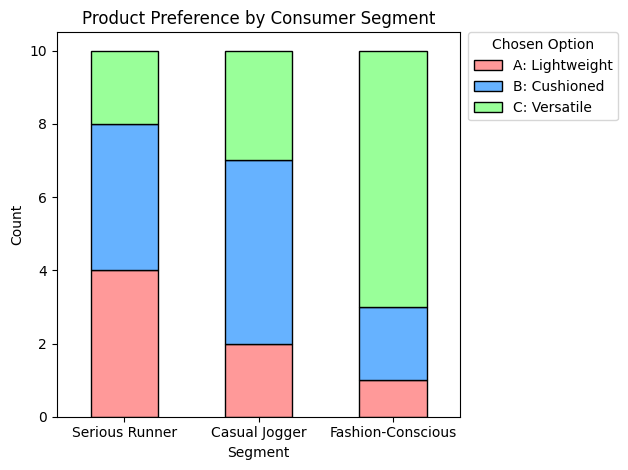

In [12]:
import seaborn as sns

# Create a crosstab: Segment x Preference
pivot = pd.crosstab(df['segment'], df['preferred_option'])

# Reorder indices for logical flow
pivot = pivot.reindex(index=['Serious Runner', 'Casual Jogger', 'Fashion-Conscious'], 
                      columns=['A', 'B', 'C'])

# Fill NaN with 0 for cleaner plotting
pivot = pivot.fillna(0)

# Plotting
plt.figure(figsize=(10, 6))
ax = pivot.plot(kind='bar',
                stacked=True,
                color=['#FF9999', '#66B2FF', '#99FF99'],
                edgecolor='black')

ax.set_title("Product Preference by Consumer Segment")
ax.set_ylabel("Count")
ax.set_xlabel("Segment")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.legend(title="Chosen Option",
          labels=['A: Lightweight', 'B: Cushioned', 'C: Versatile'],
          bbox_to_anchor=(1.02, 1),
          loc='upper left',
          borderaxespad=0.)

plt.tight_layout()
plt.show()


### Insights
- **Segment patterns:** Serious Runners mostly split between A (lightweight) and B (cushioned), Casual Joggers skew toward B, and Fashion-Conscious shoppers tend to choose C (versatile).
- **Interesting exceptions:** Not everyone behaves like their label. For example, Erik (47, CFO, Casual Jogger) picks A like a performance runner. He selected the "minimalist" shoe not for racing, but because it aligned with his efficiency-driven, disciplined personality.James (74) is a lifetime Serious Runner who now chooses B for joint protection.
- **Implementation Idea** The simulation revealed new storytelling angles on top of the technical specs.
  - **Concept A (The Essentialist)**: Beyond lightweight/speed, market the "functional beauty" to efficiency-seekers like Erik. 
  - **Concept B (The Long Game)**: Beyond stability, market the "investment in the body." Frame it as an insurance policy for longevity: "Run again tomorrow."
  - **Concept C (The Seamless Life)**: Beyond versatility, market the "time efficiency" for busy urbanites. Highlight it as the gear for a life with "no time to switch gears."

In [ ]:
# Close TinyTroupe cache
control.end()